In [ ]:
import json
import xarray as xr
import rioxarray
import numpy as np
import scipy
import cartopy.crs as ccrs
import cartopy.feature as cf
from matplotlib import pyplot as plt
import matplotlib as mpl
from pathlib import Path
from fiweps.util import coordutil as co

## Config & prep

### Constants and paths

In [ ]:
bins = np.arange(0, 0.7, 0.1)
cmap = plt.get_cmap('Blues', len(bins))
norm = mpl.colors.BoundaryNorm(boundaries=bins, ncolors=len(bins)-1 )

In [ ]:
configdir = Path("../config/dscale/")

with open(configdir / "domains_03_extent.json") as src:
    extent = json.load(src)
extent

{'d01': {'west': 161, 'east': -108, 'north': 76, 'south': 50},
 'd02': {'west': -178, 'east': -128, 'north': 72, 'south': 55}}

In [ ]:
co.deg180_360(extent['d01']['east'])

252

In [ ]:
maskdir = Path("/Volumes/CWMobileSSD/Climate/ERA5/masks/")
datadirJRA = Path("/Volumes/CWMobileSSD/Climate/JRA55/snow")
january_JRA55 = datadirJRA / "anl_land.065_snwe.reg_tl319.2021010100_2021013118"
april_JRA55 = datadirJRA / "anl_land.065_snwe.reg_tl319.2021040100_2021043018"
june_JRA55 = datadirJRA / "anl_land.065_snwe.reg_tl319.2021060100_2021063018"
datadirERA = Path("/Volumes/CWMobileSSD/Climate/ERA5/sd_grib")
january_ERA5 = datadirERA / "e5.oper.an.sfc.128_141_sd.ll025sc.2021010100_2021013123.grb"
april_ERA5 = datadirERA / "e5.oper.an.sfc.128_141_sd.ll025sc.2021040100_2021043023.grb"
june_ERA5 = datadirERA / "e5.oper.an.sfc.128_141_sd.ll025sc.2021060100_2021063023.grb"
datadirNC = Path("/Volumes/CWMobileSSD/Climate/ERA5/sd_netcdf/")

### Helpers

In [ ]:
def get_2Dtemplate(ds, roimask_in=None):
    template_data = np.ones((len(ds.latitude), len(ds.longitude)))
    template_lats = ds.latitude
    template_lons = ds.longitude
    templateDS = xr.DataArray(template_data, 
        coords=[template_lats, template_lons], 
        dims=["latitude", "longitude"])
    if roimask_in is not None:
        templateDS = templateDS.where(roimask_in==1)
    return templateDS

def get_subsetted_array(ds, extent):
    return ds.sel(
    latitude=slice(extent['d01']['north'], extent['d01']['south']),
    longitude=slice(co.deg180_360(extent['d01']['west']), co.deg180_360(extent['d01']['east']))
    )

with xr.load_dataset(maskdir / "glaciermask_thresh_1m.nc", engine="netcdf4") as ds:
    glaciermask = ds.glaciermask
glaciermask


<xarray.DataArray 'glaciermask' (latitude: 721, longitude: 1440)>
array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])
Coordinates:
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
    crs        <U1 ''
Attributes:
    title:        ERA5-gridded glacier mask for threshold=1.0 for snow water ...
    institution:  International Arctic Research Center, UAF
    source:       Python, data file version  0.9
    author:       Chris Waigl cwaigl@alaska.edu 
    history:      2023-02-02 04:49:39.775844

month number 1
month number 2
month number 3
month number 4
month number 5
month number 6


/Users/chris/mambaforge/envs/dyndowntools/lib/python3.11/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/chris/mambaforge/envs/dyndowntools/lib/python3.11/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/chris/mambaforge/envs/dyndowntools/lib/python3.11/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/chris/mambaforge/envs/dyndowntools/lib/python3.11/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/chris/mambaforge/envs/dyndowntools/lib/python3.11/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/chris/mambaforge/envs/dyndowntools/lib/python3.11/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encou

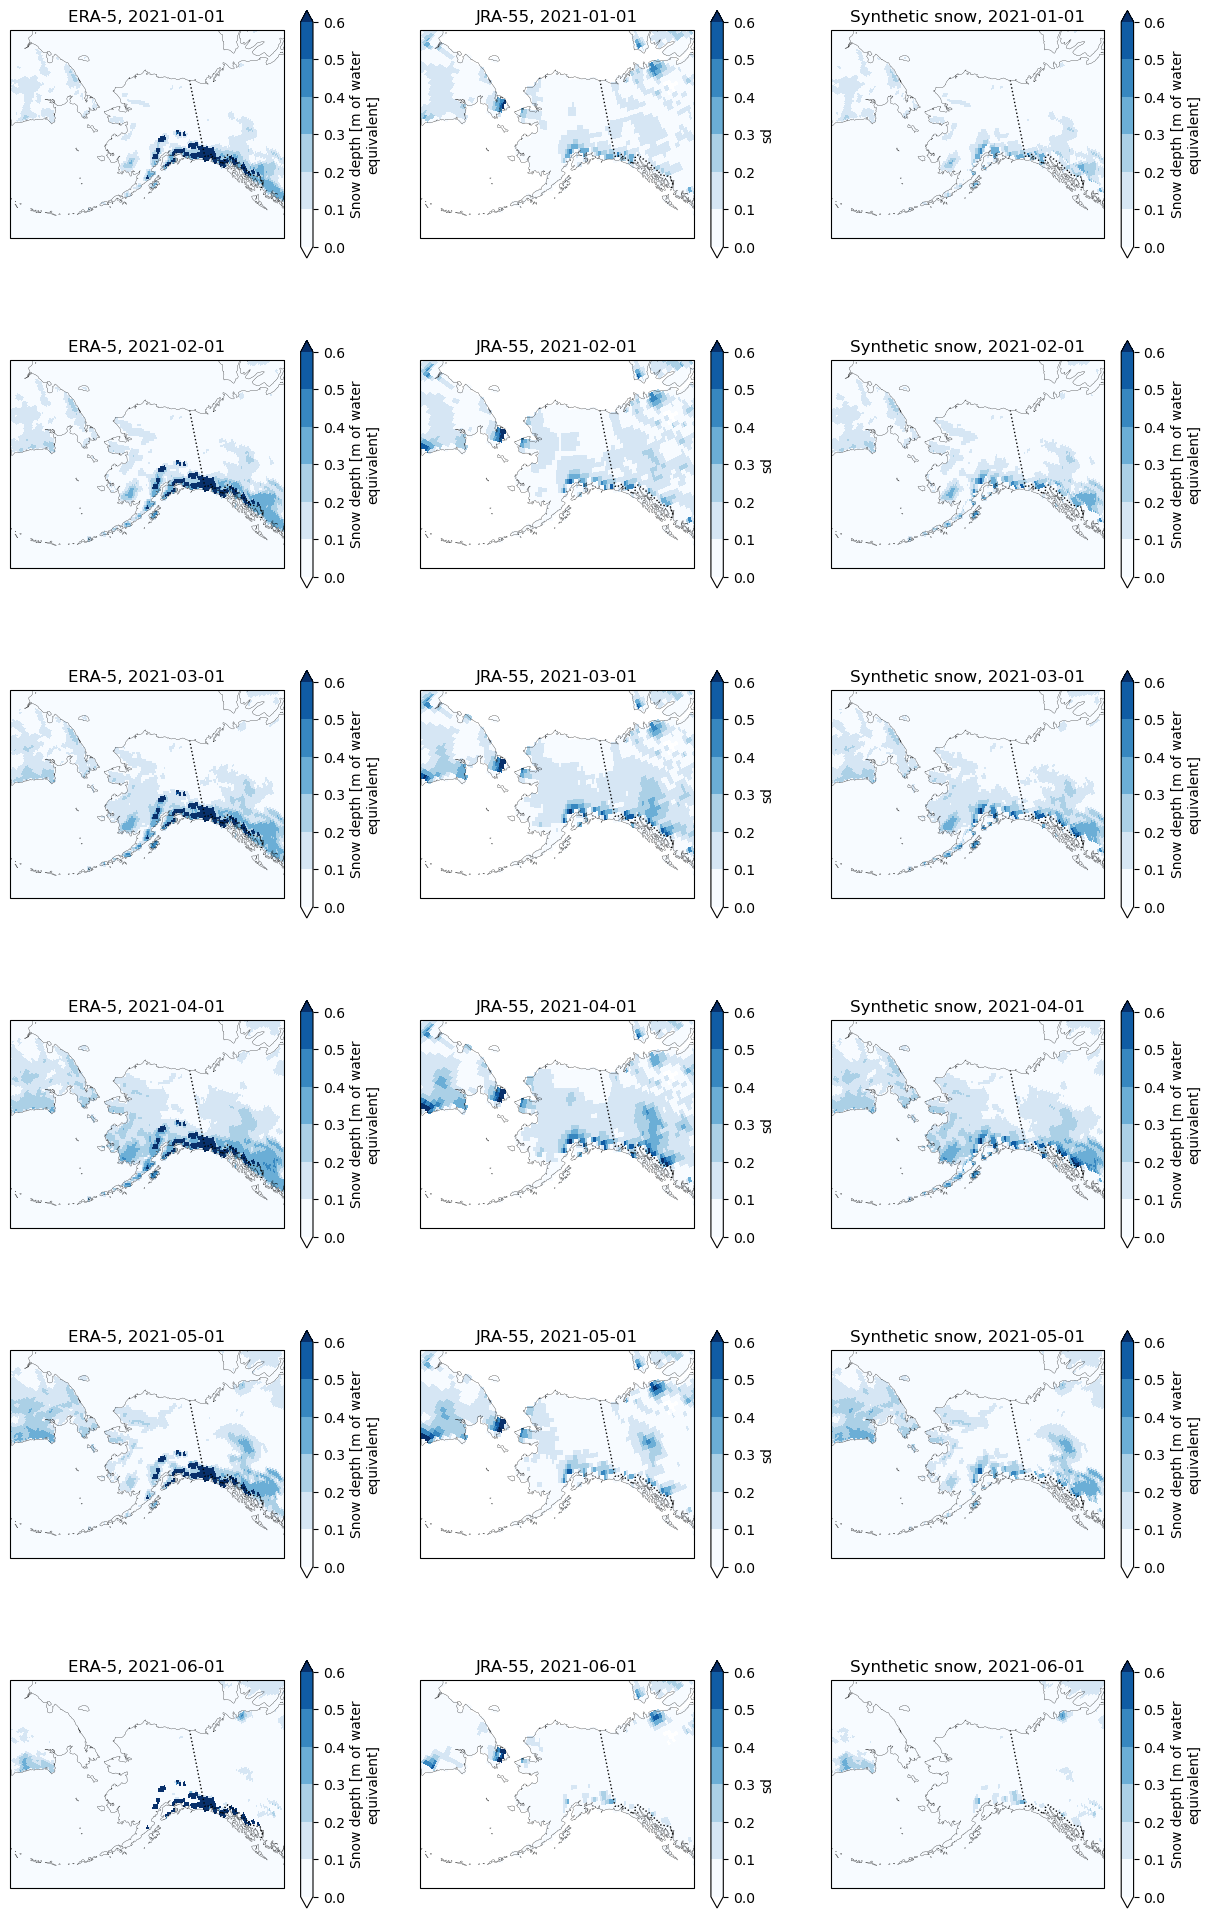

In [ ]:
projection = ccrs.AlbersEqualArea(
central_longitude=-154.0, central_latitude=50.0, 
standard_parallels=(55.0, 65.0))

glaciermask_expand = scipy.ndimage.binary_dilation(glaciermask.data, iterations=3)


JRA55_pths = sorted(datadirJRA.glob("anl_land.065_*8"))
ERA5_pths = sorted(datadirERA.glob("e5.oper.an.sfc*.grb"))
datapairs = list(zip(JRA55_pths, ERA5_pths))
fig, axs = plt.subplots(nrows=len(datapairs),ncols=3,
                        subplot_kw={'projection': projection},
                        figsize=(15,25))
for ax in axs.flatten():
    ax.set_extent([-180, -130, 48, 75])
    ax.coastlines(linewidth=0.2)
    ax.add_feature(cf.BORDERS, linestyle=':')


for idx, (dsJRA, dsERA) in enumerate(datapairs): 
    print(f"month number {idx+1}")
    with xr.open_dataset(dsERA, engine="cfgrib") as ds_ERA:
        with xr.open_dataset(dsJRA, engine="cfgrib") as ds_JRA:
#            templateDS = get_2Dtemplate(ds_ERA)
            ds_ERA.sd.isel(time=0).plot(
                cmap=cmap, norm=norm, 
#                add_colorbar=False,
                cbar_kwargs={'ticks': bins, 'extend': 'both', "shrink": 0.9},
                transform=ccrs.PlateCarree(),
                ax=axs[idx][0],
            )
            axs[idx][0].set_title(f"ERA-5, {ds_ERA.time[0].dt.strftime('%Y-%m-%d').data}")
            plotraster = ds_JRA.sd.isel(time=0) / 1000
            plotraster.plot(
                cmap=cmap, norm=norm, 
#                add_colorbar=False,
                cbar_kwargs={'ticks': bins, 'extend': 'both', "shrink": 0.9},
                transform=ccrs.PlateCarree(),
                ax=axs[idx][1],
            )
            axs[idx][1].set_title(f"JRA-55, {ds_JRA.time[0].dt.strftime('%Y-%m-%d').data}")
            ds_JRA_ERA = ds_JRA.fillna(0).interp(
                latitude=ds_ERA.latitude, longitude=ds_ERA.longitude, method='nearest') / 1000
            combined_DS = ds_ERA.where(glaciermask_expand==0).isel(time=0).combine_first(ds_JRA_ERA.isel(time=0))
#            ds_JRA_ERA.sd.isel(time=0).plot(
            combined_DS.sd.plot(
                cmap=cmap, norm=norm, 
                cbar_kwargs={'ticks': bins, 'extend': 'both', "shrink": 0.9},
                transform=ccrs.PlateCarree(),
                ax=axs[idx][2],
            )
            #axs[idx][2].set_title(f"Synthetic Snow, {ds_JRA.time[0].dt.strftime('%Y-%m-%d').data}")
            axs[idx][2].set_title(f"Synthetic snow, {ds_JRA.time[0].dt.strftime('%Y-%m-%d').data}")
            




## prototype area for glacier masked / combined snow

In [ ]:
ds = xr.open_dataset(datadirNC / "reanalysis-era5-single-levels_sd_2021_04.nc")
april_sd_era5 = ds.sd.isel(time=0)
april_sd_era5.where(april_sd_era5 > 0.1)

<xarray.DataArray 'sd' (latitude: 721, longitude: 1440)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [10., 10., 10., ..., 10., 10., 10.],
       [10., 10., 10., ..., 10., 10., 10.],
       [10., 10., 10., ..., 10., 10., 10.]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
    time       datetime64[ns] 2021-04-01
Attributes:
    units:          m of water equivalent
    long_name:      Snow depth
    standard_name:  lwe_thickness_of_surface_snow_amount

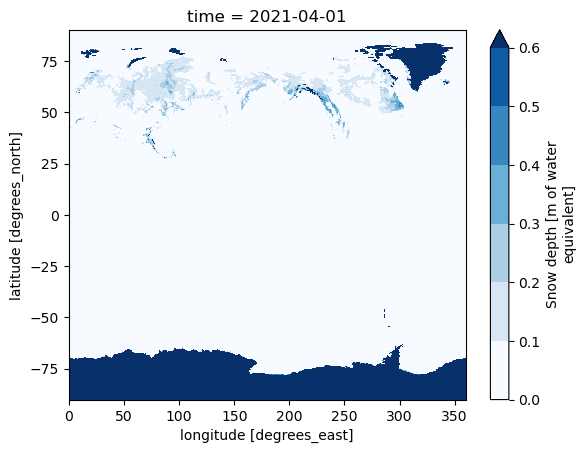

In [ ]:
april_sd_era5.plot(cmap=cmap, norm=norm)

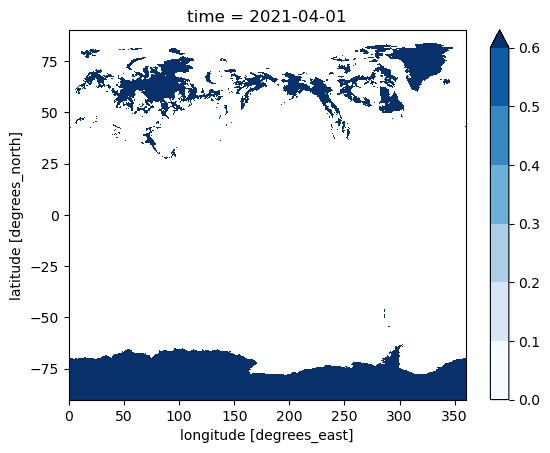

In [ ]:
templateDS = get_2Dtemplate(ds)
templateDS = templateDS.where(april_sd_era5 > 0.1, 0)
templateDS.where(templateDS==1).plot(cmap=cmap, norm=norm)

In [ ]:
ds_ERA_june = xr.open_dataset(datadirNC / "reanalysis-era5-single-levels_sd_2021_06.nc")
ds_ERA_june.sd.isel(time=0)

<xarray.DataArray 'sd' (latitude: 721, longitude: 1440)>
[1038240 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
    time       datetime64[ns] 2021-06-01
Attributes:
    units:          m of water equivalent
    long_name:      Snow depth
    standard_name:  lwe_thickness_of_surface_snow_amount

In [ ]:
ds_JRA55_june = xr.open_dataset(june_JRA55, engine="cfgrib")
# ds_JRA55_june = get_subsetted_array(ds_JRA55_june, extent=extent)
ds_JRA55_june.sd.isel(time=0)

<xarray.DataArray 'sd' (latitude: 320, longitude: 640)>
[204800 values with dtype=float32]
Coordinates:
    time        datetime64[ns] 2021-06-01
    step        timedelta64[ns] ...
    surface     float64 ...
  * latitude    (latitude) float64 89.57 89.01 88.45 ... -88.45 -89.01 -89.57
  * longitude   (longitude) float64 0.0 0.5625 1.125 1.688 ... 358.3 358.9 359.4
    valid_time  datetime64[ns] ...
Attributes: (12/24)
    GRIB_paramId:                             228141
    GRIB_numberOfPoints:                      204800
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    GRIB_gridType:                            regular_gg
    ...                                       ...
    GRIB_name:                                Snow depth water equivalent
    GRIB_shortName:                           sd
    GRIB_units:                               kg m**-2
    long_name:                                Snow depth water equivalent
    units:                                    kg m**-2
    standard_name:                            unknown

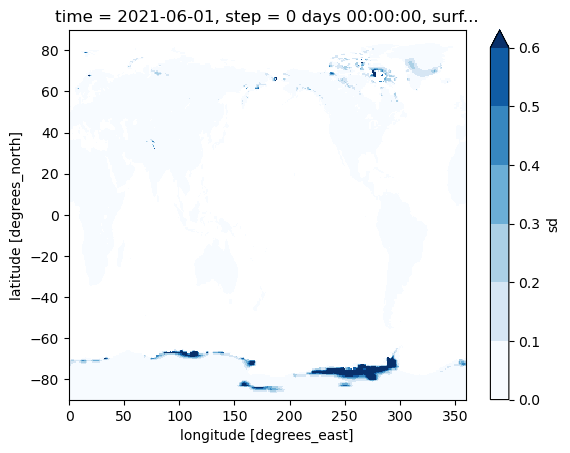

In [ ]:
(ds_JRA55_june.sd.isel(time=0) / 1000).plot(cmap=cmap, norm=norm)

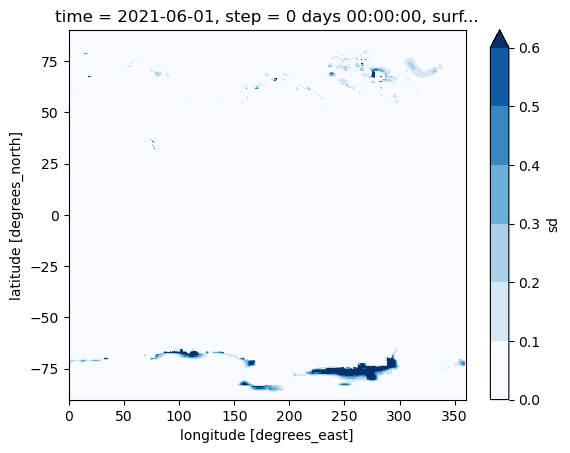

In [ ]:
ds_JRA_ERA = ds_JRA55_june.fillna(0).interp(
    latitude=ds_ERA_june.latitude, longitude=ds_ERA_june.longitude, method='nearest') / 1000
ds_JRA_ERA.sd.isel(time=0).plot(cmap=cmap, norm=norm)

In [ ]:
ds_JRA_ERA.sd.isel(time=0).max()

<xarray.DataArray 'sd' ()>
array(1.7376709, dtype=float32)
Coordinates:
    time        datetime64[ns] 2021-06-01
    step        timedelta64[ns] 00:00:00
    surface     float64 0.0
    valid_time  datetime64[ns] 2021-06-01

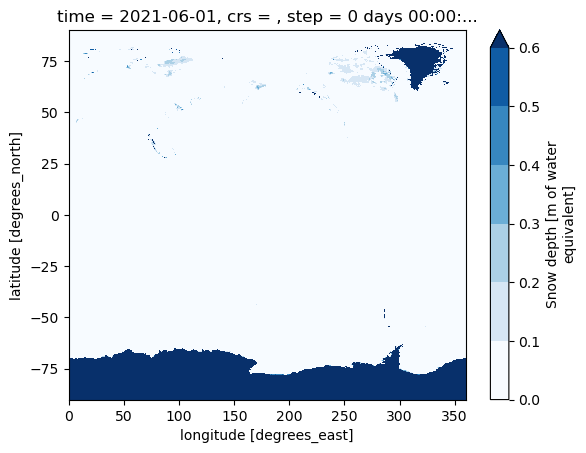

In [ ]:
combined_DS = ds_ERA_june.sd.where(glaciermask==0).isel(time=0).combine_first(ds_JRA_ERA.isel(time=0))
combined_DS.sd.plot(cmap=cmap, norm=norm)

#### plot synthetic snow

/Users/chris/mambaforge/envs/dyndowntools/lib/python3.11/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/chris/mambaforge/envs/dyndowntools/lib/python3.11/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/chris/mambaforge/envs/dyndowntools/lib/python3.11/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/chris/mambaforge/envs/dyndowntools/lib/python3.11/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/chris/mambaforge/envs/dyndowntools/lib/python3.11/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/chris/mambaforge/envs/dyndowntools/lib/python3.11/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encou

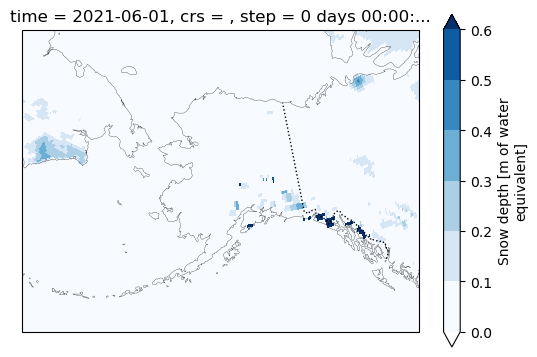

In [ ]:
projection = ccrs.AlbersEqualArea(
    central_longitude=-154.0, central_latitude=50.0, 
    standard_parallels=(55.0, 65.0))
ax = plt.axes(projection=projection)
ax.set_extent([-180, -130, 48, 75])
ax.coastlines(linewidth=0.2)
ax.add_feature(cf.BORDERS, linestyle=':')
combined_DS.sd.plot(
    cmap=cmap, norm=norm, 
    cbar_kwargs={'ticks': bins, 'extend': 'both', "shrink": 0.9},
    transform=ccrs.PlateCarree(),
    ax=ax,
)

### check values of combined DS

In [ ]:
import scipy

In [ ]:
glaciermask_expand = scipy.ndimage.binary_dilation(glaciermask.data, iterations=3)

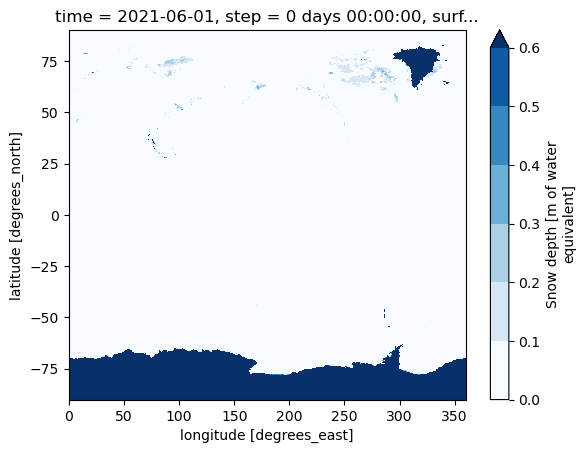

In [ ]:
combined_DS_expand = ds_ERA_june.sd.where(glaciermask_expand==0).isel(time=0).combine_first(ds_JRA_ERA.isel(time=0))
combined_DS_expand.sd.plot(cmap=cmap, norm=norm)

In [ ]:
combined_DS_AK = get_subsetted_array(combined_DS_expand, extent)
combined_DS_AK.sd.max()

<xarray.DataArray 'sd' ()>
array(0.42100906, dtype=float32)
Coordinates:
    time        datetime64[ns] 2021-06-01
    step        timedelta64[ns] 00:00:00
    surface     float64 0.0
    valid_time  datetime64[ns] 2021-06-01

/Users/chris/mambaforge/envs/dyndowntools/lib/python3.11/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/chris/mambaforge/envs/dyndowntools/lib/python3.11/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/chris/mambaforge/envs/dyndowntools/lib/python3.11/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/chris/mambaforge/envs/dyndowntools/lib/python3.11/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/chris/mambaforge/envs/dyndowntools/lib/python3.11/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/chris/mambaforge/envs/dyndowntools/lib/python3.11/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encou

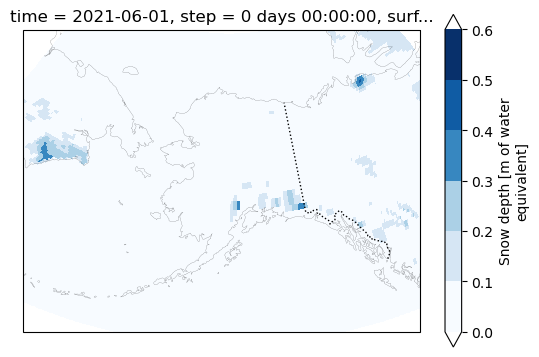

In [ ]:
projection = ccrs.AlbersEqualArea(
    central_longitude=-154.0, central_latitude=50.0, 
    standard_parallels=(55.0, 65.0))
ax = plt.axes(projection=projection)
ax.set_extent([-180, -130, 48, 75])
ax.coastlines(linewidth=0.1)
ax.add_feature(cf.BORDERS, linestyle=':')
combined_DS_AK.sd.plot(
    cmap=cmap, norm=norm, 
    cbar_kwargs={'ticks': bins, 'extend': 'both', "shrink": 0.9},
    transform=ccrs.PlateCarree(),
    ax=ax,
)

### plot JRA 55

/Users/chris/mambaforge/envs/dyndowntools/lib/python3.11/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/chris/mambaforge/envs/dyndowntools/lib/python3.11/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/chris/mambaforge/envs/dyndowntools/lib/python3.11/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/chris/mambaforge/envs/dyndowntools/lib/python3.11/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/chris/mambaforge/envs/dyndowntools/lib/python3.11/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/chris/mambaforge/envs/dyndowntools/lib/python3.11/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encou

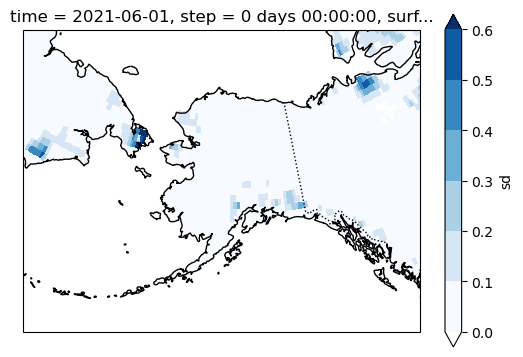

In [ ]:
projection = ccrs.AlbersEqualArea(
    central_longitude=-154.0, central_latitude=50.0, 
    standard_parallels=(55.0, 65.0))
ax = plt.axes(projection=projection)
ax.set_extent([-180, -130, 48, 75])
ax.coastlines()
ax.add_feature(cf.BORDERS, linestyle=':')
plotraster = ds.sd.isel(time=0) / 1000
plotraster.plot(
    cmap=cmap, norm=norm, 
    cbar_kwargs={'ticks': bins, 'extend': 'both', "shrink": 0.9},
    transform=ccrs.PlateCarree(),
    ax=ax,
)

/Users/chris/mambaforge/envs/dyndowntools/lib/python3.11/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/chris/mambaforge/envs/dyndowntools/lib/python3.11/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/chris/mambaforge/envs/dyndowntools/lib/python3.11/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/chris/mambaforge/envs/dyndowntools/lib/python3.11/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/chris/mambaforge/envs/dyndowntools/lib/python3.11/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/chris/mambaforge/envs/dyndowntools/lib/python3.11/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encou

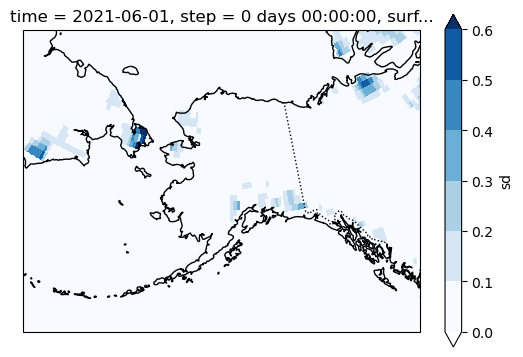

In [ ]:
projection = ccrs.AlbersEqualArea(
    central_longitude=-154.0, central_latitude=50.0, 
    standard_parallels=(55.0, 65.0))
ax = plt.axes(projection=projection)
ax.set_extent([-180, -130, 48, 75])
ax.coastlines()
ax.add_feature(cf.BORDERS, linestyle=':')
ds_JRA_ERA.sd.isel(time=0).plot(
    cmap=cmap, norm=norm, 
    cbar_kwargs={'ticks': bins, 'extend': 'both', "shrink": 0.9},
    transform=ccrs.PlateCarree(),
    ax=ax,
)

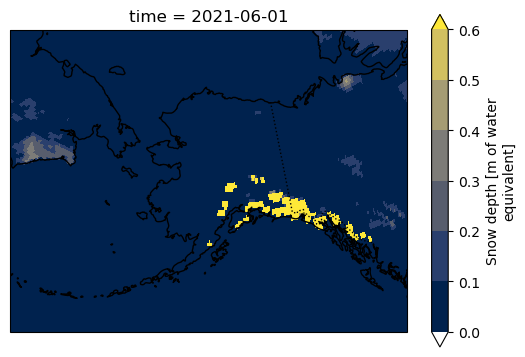

In [ ]:
projection = ccrs.AlbersEqualArea(
    central_longitude=-154.0, central_latitude=50.0, 
    standard_parallels=(55.0, 65.0))
ax = plt.axes(projection=projection)
ax.set_extent([-180, -130, 48, 75])
ax.coastlines()
ax.add_feature(cf.BORDERS, linestyle=':')
ds_ERA.sd.isel(time=0).plot(
    cmap=cmap, norm=norm, 
    cbar_kwargs={'ticks': bins, 'extend': 'both', "shrink": 0.9},
    transform=ccrs.PlateCarree(),
    ax=ax,
)

< GeoAxes: +proj=aea +ellps=WGS84 +lon_0=-154.0 +lat_0=50.0 +x_0=0.0 +y_0=0.0 +lat_1=55.0 +lat_2=65.0 +no_defs +type=crs >


Can't read index file '/Volumes/CWMobileSSD/Climate/ERA5/sd_grib/e5.oper.an.sfc.128_141_sd.ll025sc.2021040100_2021043023.grb.923a8.idx'
Traceback (most recent call last):
  File "/Users/christine/miniconda3/envs/dyndown/lib/python3.11/site-packages/cfgrib/messages.py", line 547, in from_indexpath_or_filestream
    self = cls.from_indexpath(indexpath)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/christine/miniconda3/envs/dyndown/lib/python3.11/site-packages/cfgrib/messages.py", line 429, in from_indexpath
    index = pickle.load(file)
            ^^^^^^^^^^^^^^^^^
EOFError: Ran out of input


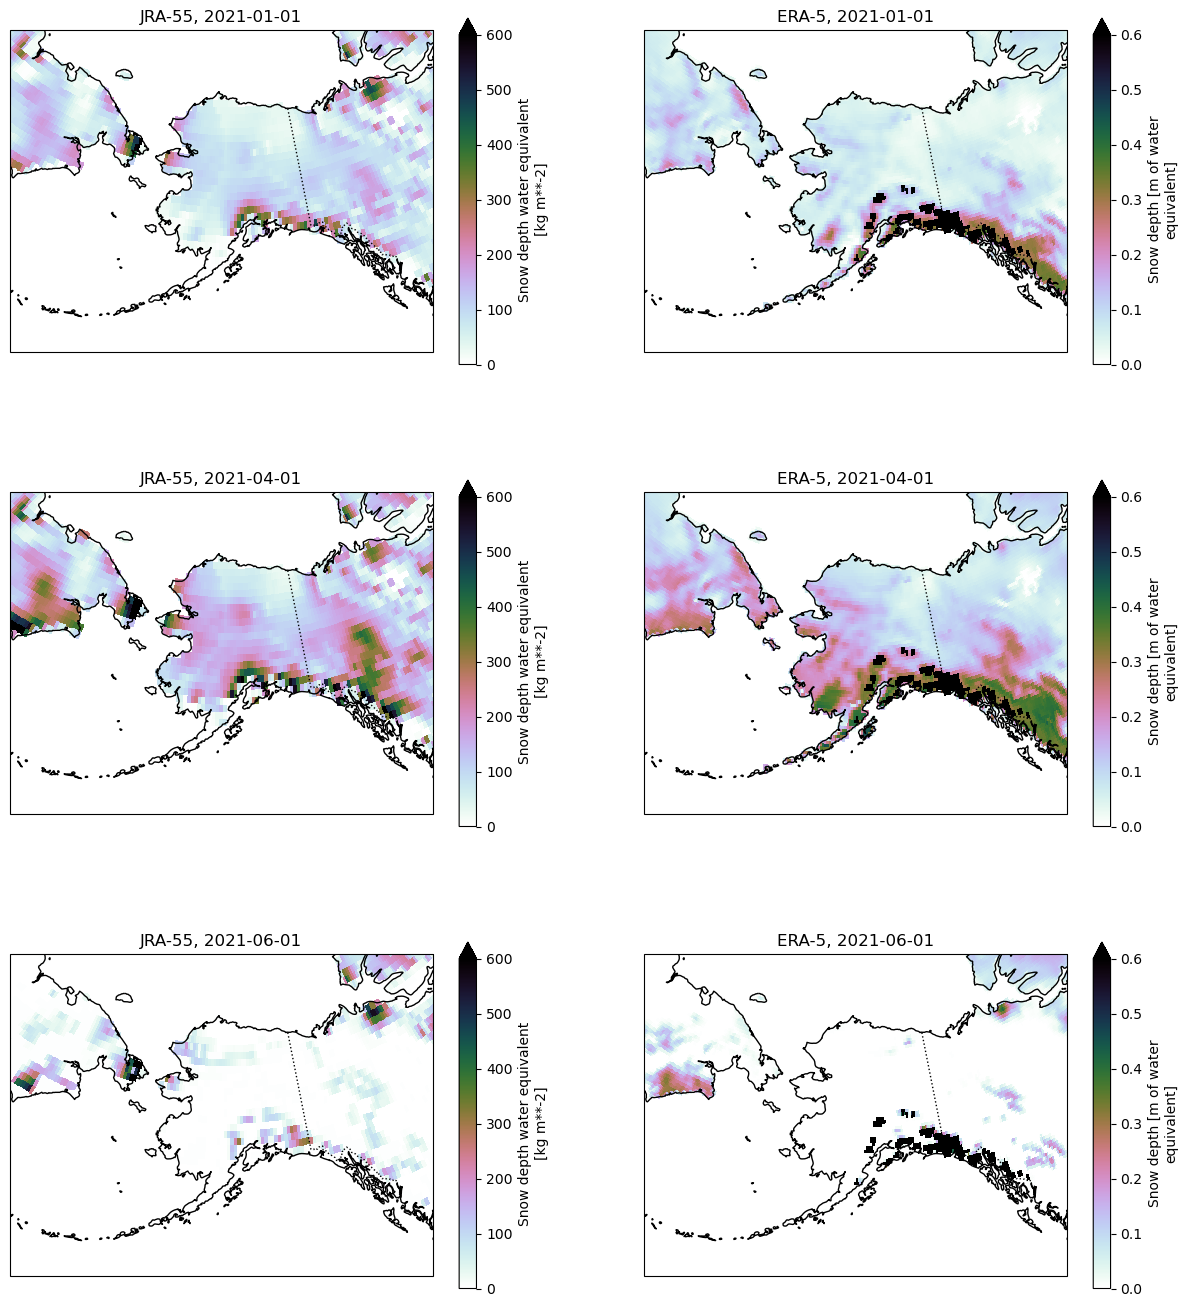

In [ ]:
fig, axs = plt.subplots(nrows=3,ncols=2,
                        subplot_kw={'projection': projection},
                        figsize=(15,17))
for ax in axs.flatten():
    ax.set_extent([-180, -130, 48, 75])
    ax.coastlines()
    ax.add_feature(cf.BORDERS, linestyle=':')

with xr.open_dataset(january_JRA55, engine="cfgrib") as ds:
    ds.sd.isel(time=0).plot(
        cmap=plt.cm.cubehelix_r, cbar_kwargs={"shrink": 0.9},
        transform=ccrs.PlateCarree(),
        ax=axs[0][0],
        vmax=600
    )
    axs[0][0].set_title(f"JRA-55, {ds.time[0].dt.strftime('%Y-%m-%d').data}")
with xr.open_dataset(april_JRA55, engine="cfgrib") as ds:
    ds.sd.isel(time=0).plot(
        cmap=plt.cm.cubehelix_r, cbar_kwargs={"shrink": 0.9},
        transform=ccrs.PlateCarree(),
        ax=axs[1][0],
        vmax=600
    )
    axs[1][0].set_title(f"JRA-55, {ds.time[0].dt.strftime('%Y-%m-%d').data}")
with xr.open_dataset(june_JRA55, engine="cfgrib") as ds:
    ds.sd.isel(time=0).plot(
        cmap=plt.cm.cubehelix_r, cbar_kwargs={"shrink": 0.9},
        transform=ccrs.PlateCarree(),
        ax=axs[2][0],
        vmax=600
    )
    axs[2][0].set_title(f"JRA-55, {ds.time[0].dt.strftime('%Y-%m-%d').data}")
with xr.open_dataset(january_ERA5, engine="cfgrib") as ds:
    ds.sd.isel(time=0).plot(
        cmap=plt.cm.cubehelix_r, cbar_kwargs={"shrink": 0.9},
        transform=ccrs.PlateCarree(),
        ax=axs[0][1],
        vmax=0.6
    )
    axs[0][1].set_title(f"ERA-5, {ds.time[0].dt.strftime('%Y-%m-%d').data}")
with xr.open_dataset(april_ERA5, engine="cfgrib") as ds:
    ds.sd.isel(time=0).plot(
        cmap=plt.cm.cubehelix_r, cbar_kwargs={"shrink": 0.9},
        transform=ccrs.PlateCarree(),
        ax=axs[1][1],
        vmax=0.6
    )
    axs[1][1].set_title(f"ERA-5, {ds.time[0].dt.strftime('%Y-%m-%d').data}")
with xr.open_dataset(june_ERA5, engine="cfgrib") as ds:
    ds.sd.isel(time=0).plot(
        cmap=plt.cm.cubehelix_r, cbar_kwargs={"shrink": 0.9},
        transform=ccrs.PlateCarree(),
        ax=axs[2][1],
        vmax=0.6
    )
    axs[2][1].set_title(f"ERA-5, {ds.time[0].dt.strftime('%Y-%m-%d').data}")

In [ ]:
outdir = Path("/Volumes/CWMobileSSD/Climate/figures")
fig.savefig(outdir / "JRA55_ERA5_SWE_comp01.png", bbox_inches="tight", dpi=200, facecolor='white')